In [1]:
import sys
#sys.path.append("../metabolome_analysis_pymodule/")
sys.path.append("../src/phloemfinder/")

import matplotlib

import numpy as np
from utils import compute_metrics_classification
from metabolome_analysis import MetaboliteAnalysis
from feature_selection_using_ml import MetabolitePhenotypeFeatureSelection

from metabolome_analysis import MetaboliteAnalysis 
from feature_selection_using_ml import MetabolitePhenotypeFeatureSelection

from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import balanced_accuracy, precision, recall, f1
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

/Users/mgalland/opt/miniconda3/envs/sklearn/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
metabolome_analysis = MetaboliteAnalysis(
    metabolome_csv="../tests/metabolome_test_data.csv", 
    metabolome_feature_id_col="feature_id")

In [3]:
metabolome_analysis.validate_input_metabolome_df()

In [4]:
print("Number of total features before blank filtering = {0}".format(metabolome_analysis.metabolome.shape[0]))

Number of total features before blank filtering = 11059


# Filter out features (filters blank, unreliable features)

## Blank filtering

In [5]:
metabolome_analysis.discard_features_detected_in_blanks(blank_sample_contains="blank")
print("Number of total features after blank filtering = {0}".format(metabolome_analysis.metabolome.shape[0]))

Number of total features after blank filtering = 7544


## Unreliable feature filtering

In [6]:
metabolome_analysis.filter_out_unreliable_features(nb_times_detected=4)

In [7]:
metabolome_analysis.metabolome.shape

(7173, 32)

# PCA analysis

In [8]:
metabolome_analysis.compute_pca_on_metabolites(n_principal_components=10)

In [9]:
metabolome_analysis.pca_performed

True

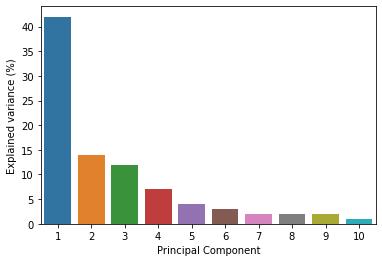

NoneType

In [10]:
type(metabolome_analysis.create_scree_plot())

In [11]:
metabolome_analysis.exp_variance
#metabolome_analysis.exp_variance.iloc[0,0]

,explained_variance
1,42.0
2,14.0
3,12.0
4,7.0
5,4.0
6,3.0
7,2.0
8,2.0
9,2.0
10,1.0


In [12]:
metabolome_analysis.metabolome_pca_reduced.shape

(32, 10)

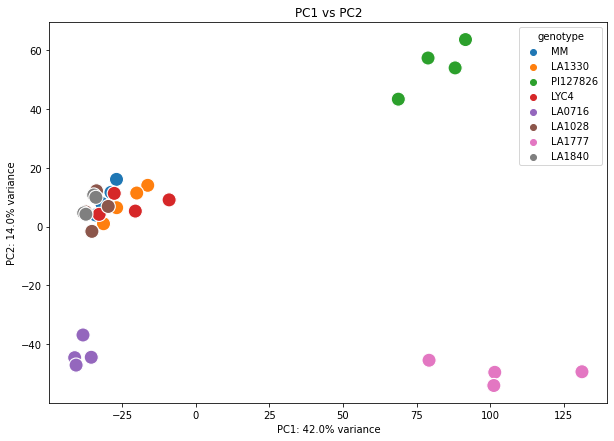

In [13]:
metabolome_analysis.create_sample_score_plot(
    pc_x_axis=1, 
    pc_y_axis=2, 
    name_grouping_var='genotype')

In [14]:
metabolome_analysis.write_clean_metabolome_to_csv(path_of_cleaned_csv="./clean_metabolome.csv")

# Feature selection

In [15]:
fs = MetabolitePhenotypeFeatureSelection(
    metabolome_csv="../tests/clean_metabolome.csv", 
    phenotype_csv="../tests/phenotypes_test_data.csv", 
    phenotype_sample_id='sample')

In [16]:
fs.validate_input_metabolome_df()

Metabolome data validated.


In [17]:
fs.validate_input_phenotype_df()

Phenotype data validated.


## Base performance

In [18]:
fs.get_baseline_performance()

Performing a simple Random Forest model training
N samples: 32
N features: 780
Average balanced_accuracy score of the default model is: 87.50 % -/+ 19.40


## Best ML model

## Correlated features in metabolome?

## tpot tryout

In [19]:
X = fs.metabolome.transpose().to_numpy(dtype='float64')
y = fs.phenotype.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9, 
    random_state=123, 
    stratify=y)

In [20]:
%%capture --no-display
from tpot import TPOTClassifier

tpot = TPOTClassifier(
    max_eval_time_mins=0.5, 
    max_time_mins=1,
    cv=3,
    random_state=123, 
    verbosity=0)

In [21]:
#%%capture --no-display
tpot.fit(X_train, y_train)

TPOTClassifier(cv=3, max_eval_time_mins=0.5, max_time_mins=4, random_state=123)

In [32]:
tpot.fitted_pipeline_

Pipeline(steps=[('binarizer', Binarizer(threshold=0.5)),
                ('gaussiannb', GaussianNB())])

In [30]:
from sklearn.pipeline import make_pipeline
best_pipeline = make_pipeline(tpot.fitted_pipeline_)
best_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('binarizer', Binarizer(threshold=0.5)),
                                 ('gaussiannb', GaussianNB())]))])

In [33]:
from tpot.export_utils import set_param_recursive

if len(best_pipeline) == 1:
    # one step pipeline thus one model  
    one_step_pipeline = best_pipeline["pipeline"][-1]
    one_step_pipeline.fit(X_train, y_train)
    print(one_step_pipeline.score(X_test, y_test))
    predictions = one_step_pipeline.predict(X_test)
    print(compute_metrics_classification(predictions, y_test, positive_class='resistant'))
else:
    # multiple steps pipeline
    n_steps_pipeline = make_pipeline(tpot.fitted_pipeline_)
    n_steps_pipeline.fit(X_train, y_train)
    predictions = n_steps_pipeline.predit(X_test)
    print(compute_metrics_classification(predictions, y_test, positive_class='resistant'))




1.0
balanced_accuracy    1.0
precision            1.0
recall               1.0
f1 score             1.0
Name: value, dtype: float64


In [41]:
from utils import compute_metrics_classification

best_pipeline.fit(X, y)
pipeline_predictions = best_pipeline.predict(X)
metrics = compute_metrics_classification(y_predictions=pipeline_predictions, y_trues=y, positive_class='resistant')

In [43]:
metrics

balanced_accuracy    1.0
precision            1.0
recall               1.0
f1 score             1.0
Name: value, dtype: float64

In [25]:
X_test

array([[  724.,   774.,  1078., ...,  5000.,   252.,     0.],
       [  850.,  1098.,   674., ..., 52414.,  2430.,   300.],
       [  536.,   818.,   798., ..., 71044.,  2414.,     0.],
       [ 1414.,   770.,  1072., ..., 42098.,   920.,  1842.]])

In [26]:
from sklearn.inspection import permutation_importance
feature_importances = permutation_importance(best_pipeline, X, y, n_repeats=10)

In [27]:
pd.DataFrame(feature_importances["importances_mean"], columns=["mean_var_imp"])

for i in feature_importances.importances_mean.argsort()[::-1]:
    if feature_importances.importances_mean[i] - 2 * feature_importances.importances_std[i] > 0:
        print(f"{fs.metabolome.index.values[i]:<8}", f"{feature_importances.importances_mean[i]:.10f}", f" +/- {feature_importances.importances_std[i]:.10f}")


NameError: name 'pd' is not defined

In [ ]:
cor_X = pd.DataFrame(X).corr()
cor_X.shape

(780, 780)

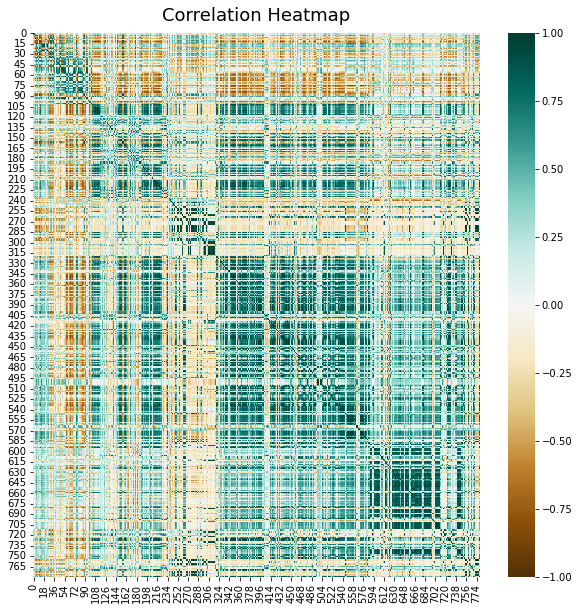

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cor_X, vmax=1, vmin=-1, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()